In [1]:
from argparser import argparser


In [105]:
from torch import nn, optim
import time
import torch
import torch.nn.functional as F


# Load MNIST

In [3]:
from config import config_dataloader, load_config
args=argparser(args=["--config", "config/mninst_ach.json"])

In [4]:
conf = load_config(args)
train_data, test_data = config_dataloader(conf, **conf['training_params']['loader_params'])

loading config file: config/mninst_ach.json


In [5]:
dataiter = iter(train_data)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([256, 1, 28, 28])
torch.Size([256])


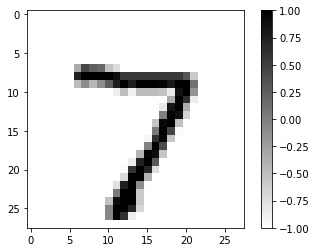

In [48]:
import matplotlib.pyplot as plt
def plot_digit(image):
    if len(image.shape) == 1:
        side = int(image.shape[0]**0.5+0.0001)
        image = image.view((side, side))
    plt.imshow(image.numpy().squeeze(), cmap='gray_r');
    plt.colorbar()
    
plot_digit(images[0])

In [7]:
# Layer details for the neural network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

## Regular model 

In [8]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


In [9]:
def train(model, epochs=20):
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    for e in range(epochs):
        running_loss = 0
        for images, labels in train_data:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

            # Training pass
            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, labels)

            #This is where the model learns by backpropagating
            loss.backward()

            #And optimizes its weights here
            optimizer.step()

            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_data)))

In [10]:
train(model, 20)

Epoch 0 - Training loss: 2.0507212273618007
Epoch 1 - Training loss: 0.8412431401141146
Epoch 2 - Training loss: 0.47881185399725085
Epoch 3 - Training loss: 0.3923909460610532
Epoch 4 - Training loss: 0.3529121033054717
Epoch 5 - Training loss: 0.3272516823829488
Epoch 6 - Training loss: 0.3075757210559033
Epoch 7 - Training loss: 0.2908138465374074
Epoch 8 - Training loss: 0.27531632286437013
Epoch 9 - Training loss: 0.26159210541146866
Epoch 10 - Training loss: 0.2491595353851927
Epoch 11 - Training loss: 0.2375503621836926
Epoch 12 - Training loss: 0.2266115924779405
Epoch 13 - Training loss: 0.2171965781044453
Epoch 14 - Training loss: 0.2081038087923476
Epoch 15 - Training loss: 0.19964948474092686
Epoch 16 - Training loss: 0.19199557849701415
Epoch 17 - Training loss: 0.18492326574756743
Epoch 18 - Training loss: 0.177860293997095
Epoch 19 - Training loss: 0.17221451520602754


## Testing

In [113]:
correct_count, all_count = 0, 0
for images,labels in test_data:
    for i in range(len(images)):
        img = images[i].view(1, 784)
        # Turn off gradients to speed up this part
        with torch.no_grad():
            logps = model(img)

        # Output of the network are log-probabilities, need to take exponential for probabilities
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9614


### Probability distribution of the noise

In [17]:
# Take model, datapoint

In [92]:
def get_item(test, i):
    iterator = iter(test_data)
    for j in range(i):
        iterator.next()
    return iterator.next()

image, label = get_item(test_data, 73)
image = image.view((1,-1))

In [175]:
def l_infinity_uniform_noise(data, epsilon, n_samples=1000):
    shape = (n_samples,) + data.shape[1:]
    noise = (torch.rand(shape) * 2 - 1) * epsilon
    return torch.clamp(data + noise, -1, 1)

In [176]:
perturbed = l_infinity_uniform_noise(image, 0.7, 10000)

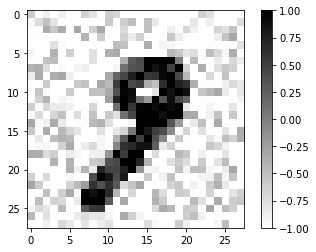

In [177]:
plot_digit(perturbed[0])

In [178]:
model(image).argmax()

tensor(9)

In [179]:
(model(perturbed).argmax(axis=1) == model(image).argmax()).float().mean()

tensor(0.5661)

In [160]:
i=0
for data, target in test_data:
    data = data.view(images.shape[0], -1)
    perturbed = l_infinity_uniform_noise(data, 0.7, 10000)
    print(i,(model(perturbed).argmax(axis=1) == model(data).argmax()).float().mean())
    i+=1

0 tensor(1.)
1 tensor(1.)
2 tensor(1.)
3 tensor(1.)
4 tensor(1.)
5 tensor(1.)
6 tensor(1.)
7 tensor(0.9999)
8 tensor(1.)
9 tensor(0.9990)
10 tensor(1.)
11 tensor(1.)
12 tensor(1.)
13 tensor(1.)
14 tensor(1.)
15 tensor(1.)
16 tensor(1.)
17 tensor(1.)
18 tensor(1.)
19 tensor(1.)
20 tensor(0.9991)
21 tensor(1.)
22 tensor(1.)
23 tensor(1.)
24 tensor(1.)
25 tensor(1.)
26 tensor(1.)
27 tensor(1.)
28 tensor(1.)
29 tensor(1.)
30 tensor(1.)
31 tensor(0.9999)
32 tensor(1.)
33 tensor(0.9178)
34 tensor(1.)
35 tensor(1.)
36 tensor(1.)
37 tensor(1.)
38 tensor(0.8681)
39 tensor(1.)
40 tensor(1.)
41 tensor(1.)
42 tensor(0.9993)
43 tensor(1.)
44 tensor(0.9999)
45 tensor(1.)
46 tensor(0.9995)
47 tensor(1.)
48 tensor(1.)
49 tensor(1.)
50 tensor(1.)
51 tensor(1.)
52 tensor(1.)
53 tensor(1.)
54 tensor(1.)
55 tensor(1.)
56 tensor(1.)
57 tensor(1.)
58 tensor(1.)
59 tensor(0.9998)
60 tensor(1.)
61 tensor(0.9982)
62 tensor(0.9005)
63 tensor(0.7940)
64 tensor(1.)
65 tensor(0.9774)
66 tensor(0.8062)
67 tensor(1.

KeyboardInterrupt: 

# Attacks

In [114]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [-1,1] range
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    # Return the perturbed image
    return perturbed_image

In [149]:
def test(model, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:
        data = data.view(images.shape[0], -1)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = nn.NLLLoss()(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [150]:
accuracies = []
examples = []

epsilons =[0, 0.001, 0.01, 0.1, 0.2, 0.3]
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, test_data, eps);
    accuracies.append(acc)
    examples.append(ex)


Epsilon: 0	Test Accuracy = 9614 / 10000 = 0.9614
Epsilon: 0.001	Test Accuracy = 9609 / 10000 = 0.9609
Epsilon: 0.01	Test Accuracy = 9520 / 10000 = 0.952
Epsilon: 0.1	Test Accuracy = 7309 / 10000 = 0.7309
Epsilon: 0.2	Test Accuracy = 2353 / 10000 = 0.2353
Epsilon: 0.3	Test Accuracy = 393 / 10000 = 0.0393


In [11]:
# Take model, take sample

# HMC 

In [181]:
import numpy as np
def logprob(x, ivar):
    logp = -0.5 * np.sum(ivar * x**2)
    grad = -ivar * x
    return logp, grad
# run the sampler
from pyhmc import hmc
ivar = 1. / np.random.rand(5)
samples = hmc(logprob, x0=np.random.randn(5), args=(ivar,), n_samples=1000)

so p(x)

p(x) = 

# Certified robust 

In [3]:
from train import main
main(args)

loading config file: config/mninst_ach.json
./mnist_crown/regular_dense.pth
Command line: /opt/miniconda3/envs/scvi/lib/python3.7/site-packages/ipykernel_launcher.py -f /Users/achille/Library/Jupyter/runtime/kernel-b30aaf25-e62a-4088-aa6b-b3d608f7a8b2.json
training configurations: {'method': 'robust', 'epochs': 100, 'lr': 0.0005, 'lr_decay_step': 10, 'lr_decay_factor': 0.5, 'lr_decay_milestones': [], 'weight_decay': 0.0, 'optimizer': 'adam', 'starting_epsilon': 0.0, 'epsilon': 0.3, 'schedule_length': 61, 'schedule_type': 'linear', 'norm': 'inf', 'verbose': False, 'multi_gpu': False, 'loader_params': {'batch_size': 256, 'shuffle_train': True, 'test_batch_size': 256}, 'method_params': {'batch_size': 128, 'shuffle_train': True, 'runnerup_only': False, 'activity_reg': 0.0, 'l1_reg': 0.0, 'final-beta': 0.0, 'final-kappa': 0.5, 'convex-proj': 50, 'bound_opts': {'same-slope': False, 'zero-lb': False, 'one-lb': False}, 'batch_multiplier': 1, 'bounded_input': True, 'bound_type': 'crown-interval

[ 2: 150]: eps 0.008191  Time 0.034 (0.037)  Total Loss 0.2880 (0.3082)  L1 Loss 0.0000 (0.0000)  CE 0.2127 (0.2389)  RCE 0.2880 (0.3082)  Err 0.0391 (0.0684)  Rob Err 0.0664 (0.0880)  Uns 10.9 (9.6)  Dead 29.0 (28.9)  Alive 152.1 (153.5)  Tightness 10.92188 (9.58004)  Bias -0.56856 (-0.46729)  Diff 37.66497 (30.62593)  R 40.722  beta 0.973 (0.973)  kappa 1.000 (1.000)  
[ 2: 200]: eps 0.009255  Time 0.034 (0.036)  Total Loss 0.2338 (0.3115)  L1 Loss 0.0000 (0.0000)  CE 0.1501 (0.2364)  RCE 0.2338 (0.3115)  Err 0.0430 (0.0677)  Rob Err 0.0664 (0.0890)  Uns 11.9 (10.0)  Dead 30.3 (29.1)  Alive 149.8 (152.9)  Tightness 11.92188 (9.99201)  Bias -0.95675 (-0.57513)  Diff 41.31619 (32.82769)  R 34.971  beta 0.969 (0.969)  kappa 1.000 (1.000)  
[FINAL RESULT epoch: 2 eps:0.0100]: Time 0.017 (0.036)  Total Loss 0.3730 (0.3104)  L1 Loss 0.0000 (0.0000)  CE 0.2866 (0.2321)  RCE 0.3730 (0.3104)  Uns 12.021 (10.243)  Dead 30.1 (29.3)  Alive 149.9 (152.4)  Tight 12.02083 (10.24343)  Bias -0.83066 

[ 5:  50]: eps 0.021064  Time 0.031 (0.039)  Total Loss 0.3256 (0.3682)  L1 Loss 0.0000 (0.0000)  CE 0.1323 (0.1661)  RCE 0.3256 (0.3682)  Err 0.0508 (0.0491)  Rob Err 0.0977 (0.1060)  Uns 15.0 (14.8)  Dead 35.3 (34.7)  Alive 141.6 (142.5)  Tightness 15.01172 (14.78784)  Bias -1.66080 (-1.67415)  Diff 72.23446 (71.67559)  R 31.482  beta 0.930 (0.930)  kappa 1.000 (1.000)  
[ 5: 100]: eps 0.022128  Time 0.033 (0.036)  Total Loss 0.3313 (0.3770)  L1 Loss 0.0000 (0.0000)  CE 0.1338 (0.1682)  RCE 0.3313 (0.3770)  Err 0.0430 (0.0489)  Rob Err 0.0898 (0.1093)  Uns 15.3 (14.9)  Dead 35.6 (35.0)  Alive 141.2 (142.1)  Tightness 15.29297 (14.86564)  Bias -1.69881 (-1.66890)  Diff 73.23051 (72.21384)  R 32.309  beta 0.926 (0.926)  kappa 1.000 (1.000)  
[ 5: 150]: eps 0.023191  Time 0.032 (0.036)  Total Loss 0.3586 (0.3765)  L1 Loss 0.0000 (0.0000)  CE 0.1347 (0.1646)  RCE 0.3586 (0.3765)  Err 0.0391 (0.0480)  Rob Err 0.1211 (0.1091)  Uns 15.6 (15.1)  Dead 36.2 (35.3)  Alive 140.2 (141.6)  Tightne

[ 8:   0]: eps 0.035000  Time 0.096 (0.096)  Total Loss 0.4410 (0.4410)  L1 Loss 0.0000 (0.0000)  CE 0.1189 (0.1189)  RCE 0.4410 (0.4410)  Err 0.0352 (0.0352)  Rob Err 0.1445 (0.1445)  Uns 18.9 (18.9)  Dead 41.3 (41.3)  Alive 131.8 (131.8)  Tightness 18.85156 (18.85156)  Bias -2.38988 (-2.38988)  Diff 69.64336 (69.64336)  R 29.933  beta 0.883 (0.883)  kappa 1.000 (1.000)  
[ 8:  50]: eps 0.036064  Time 0.046 (0.040)  Total Loss 0.4402 (0.4639)  L1 Loss 0.0000 (0.0000)  CE 0.1288 (0.1384)  RCE 0.4402 (0.4639)  Err 0.0430 (0.0417)  Rob Err 0.1367 (0.1366)  Uns 19.8 (19.4)  Dead 41.8 (41.5)  Alive 130.4 (131.1)  Tightness 19.83594 (19.44248)  Bias -2.67944 (-2.69902)  Diff 67.39041 (68.42806)  R 33.158  beta 0.880 (0.880)  kappa 1.000 (1.000)  
[ 8: 100]: eps 0.037128  Time 0.035 (0.037)  Total Loss 0.5224 (0.4817)  L1 Loss 0.0000 (0.0000)  CE 0.1843 (0.1437)  RCE 0.5224 (0.4817)  Err 0.0547 (0.0432)  Rob Err 0.1445 (0.1420)  Uns 19.6 (19.5)  Dead 41.4 (41.6)  Alive 131.0 (130.8)  Tightne

[FINAL RESULT epoch:10 eps:0.0500]: Time 0.003 (0.016)  Total Loss 0.2339 (0.5716)  L1 Loss 0.0000 (0.0000)  CE 0.0266 (0.1440)  RCE 0.2339 (0.5716)  Uns 16.562 (21.686)  Dead 47.4 (47.0)  Alive 128.0 (123.3)  Tight 16.56250 (21.68580)  Bias -1.45928 (-2.74819)  Diff 48.10524 (48.30892)  Err 0.0000 (0.0435)  Rob Err 0.0625 (0.1713)  R 25.952  beta 0.833 (0.833)  kappa 1.000 (1.000)  

layer 1 norm 21.17996597290039
layer 3 norm 9.127237319946289
layer 5 norm 7.451214790344238
saving to ./mnist_crown/regular_dense.pth
Epoch 11, learning rate [0.0005], epsilon 0.05 - 0.055
[11:   0]: eps 0.050000  Time 0.118 (0.118)  Total Loss 0.6646 (0.6646)  L1 Loss 0.0000 (0.0000)  CE 0.1943 (0.1943)  RCE 0.6646 (0.6646)  Err 0.0625 (0.0625)  Rob Err 0.1836 (0.1836)  Uns 22.3 (22.3)  Dead 47.0 (47.0)  Alive 122.7 (122.7)  Tightness 22.32031 (22.32031)  Bias -2.57277 (-2.57277)  Diff 47.87854 (47.87854)  R 29.759  beta 0.833 (0.833)  kappa 1.000 (1.000)  
[11:  50]: eps 0.051064  Time 0.032 (0.040)  T

[FINAL RESULT epoch:13 eps:0.0650]: Time 0.017 (0.036)  Total Loss 0.8064 (0.6971)  L1 Loss 0.0000 (0.0000)  CE 0.1593 (0.1670)  RCE 0.8064 (0.6971)  Uns 24.573 (24.201)  Dead 49.6 (48.6)  Alive 117.8 (119.2)  Tight 24.57292 (24.20050)  Bias -2.22339 (-2.30441)  Diff 32.56457 (35.14496)  Err 0.0312 (0.0490)  Rob Err 0.2188 (0.2006)  R 23.366  beta 0.783 (0.783)  kappa 1.000 (1.000)  

layer 1 norm 19.391611099243164
layer 3 norm 9.074681282043457
layer 5 norm 7.449430465698242
Epoch time: 8.6502, Total time: 114.4377
Evaluating...
[FINAL RESULT epoch:13 eps:0.0650]: Time 0.003 (0.017)  Total Loss 0.2758 (0.6885)  L1 Loss 0.0000 (0.0000)  CE 0.0340 (0.1592)  RCE 0.2758 (0.6885)  Uns 20.062 (23.981)  Dead 51.2 (49.5)  Alive 120.7 (118.5)  Tight 20.06250 (23.98080)  Bias -1.02431 (-1.97688)  Diff 31.70740 (32.38111)  Err 0.0000 (0.0452)  Rob Err 0.1875 (0.2026)  R 24.026  beta 0.783 (0.783)  kappa 1.000 (1.000)  

layer 1 norm 19.391611099243164
layer 3 norm 9.074681282043457
layer 5 norm

[16: 150]: eps 0.078191  Time 0.041 (0.039)  Total Loss 0.7256 (0.8261)  L1 Loss 0.0000 (0.0000)  CE 0.1372 (0.1874)  RCE 0.7256 (0.8261)  Err 0.0273 (0.0548)  Rob Err 0.1953 (0.2373)  Uns 25.8 (25.8)  Dead 50.3 (49.9)  Alive 115.8 (116.4)  Tightness 25.84766 (25.76485)  Bias -1.41456 (-1.27407)  Diff 23.14619 (24.28529)  R 24.055  beta 0.739 (0.739)  kappa 1.000 (1.000)  
[16: 200]: eps 0.079255  Time 0.044 (0.039)  Total Loss 0.8175 (0.8327)  L1 Loss 0.0000 (0.0000)  CE 0.1783 (0.1904)  RCE 0.8175 (0.8327)  Err 0.0508 (0.0552)  Rob Err 0.2578 (0.2389)  Uns 26.2 (25.8)  Dead 49.8 (49.9)  Alive 116.0 (116.3)  Tightness 26.20312 (25.79818)  Bias -0.34172 (-1.19878)  Diff 22.09550 (23.93915)  R 24.961  beta 0.736 (0.736)  kappa 1.000 (1.000)  
[FINAL RESULT epoch:16 eps:0.0800]: Time 0.019 (0.039)  Total Loss 0.8469 (0.8344)  L1 Loss 0.0000 (0.0000)  CE 0.2719 (0.1916)  RCE 0.8469 (0.8344)  Uns 27.115 (25.817)  Dead 49.6 (49.9)  Alive 115.2 (116.3)  Tight 27.11458 (25.81687)  Bias -1.057

[19:  50]: eps 0.091064  Time 0.033 (0.040)  Total Loss 0.9580 (0.9621)  L1 Loss 0.0000 (0.0000)  CE 0.2263 (0.2236)  RCE 0.9580 (0.9621)  Err 0.0625 (0.0606)  Rob Err 0.2500 (0.2747)  Uns 25.9 (26.0)  Dead 50.1 (50.3)  Alive 115.9 (115.6)  Tightness 25.94922 (26.03378)  Bias -0.85618 (-0.69835)  Diff 16.53714 (17.05492)  R 24.386  beta 0.696 (0.696)  kappa 1.000 (1.000)  
[19: 100]: eps 0.092128  Time 0.033 (0.037)  Total Loss 0.8395 (0.9626)  L1 Loss 0.0000 (0.0000)  CE 0.1712 (0.2221)  RCE 0.8395 (0.9626)  Err 0.0469 (0.0611)  Rob Err 0.2578 (0.2740)  Uns 26.1 (26.0)  Dead 49.8 (50.3)  Alive 116.1 (115.7)  Tightness 26.14844 (25.96867)  Bias 0.90161 (-0.67986)  Diff 15.59745 (16.77023)  R 24.598  beta 0.693 (0.693)  kappa 1.000 (1.000)  
[19: 150]: eps 0.093191  Time 0.034 (0.036)  Total Loss 0.9044 (0.9698)  L1 Loss 0.0000 (0.0000)  CE 0.1861 (0.2217)  RCE 0.9044 (0.9698)  Err 0.0508 (0.0615)  Rob Err 0.2617 (0.2766)  Uns 25.9 (26.0)  Dead 50.6 (50.3)  Alive 115.5 (115.8)  Tightnes

[22:   0]: eps 0.105000  Time 0.110 (0.110)  Total Loss 1.0655 (1.0655)  L1 Loss 0.0000 (0.0000)  CE 0.2592 (0.2592)  RCE 1.0655 (1.0655)  Err 0.0664 (0.0664)  Rob Err 0.3086 (0.3086)  Uns 26.3 (26.3)  Dead 50.1 (50.1)  Alive 115.6 (115.6)  Tightness 26.30469 (26.30469)  Bias -0.60241 (-0.60241)  Diff 11.68780 (11.68780)  R 25.138  beta 0.650 (0.650)  kappa 1.000 (1.000)  
[22:  50]: eps 0.106064  Time 0.055 (0.042)  Total Loss 1.1666 (1.0993)  L1 Loss 0.0000 (0.0000)  CE 0.2614 (0.2596)  RCE 1.1666 (1.0993)  Err 0.0742 (0.0718)  Rob Err 0.3555 (0.3155)  Uns 25.7 (25.8)  Dead 50.2 (50.0)  Alive 116.2 (116.2)  Tightness 25.67188 (25.80599)  Bias -0.80767 (-0.96806)  Diff 11.56540 (11.58317)  R 25.397  beta 0.646 (0.646)  kappa 1.000 (1.000)  
[22: 100]: eps 0.107128  Time 0.035 (0.040)  Total Loss 0.9888 (1.0928)  L1 Loss 0.0000 (0.0000)  CE 0.2153 (0.2592)  RCE 0.9888 (1.0928)  Err 0.0547 (0.0704)  Rob Err 0.2617 (0.3117)  Uns 25.4 (25.9)  Dead 50.2 (49.9)  Alive 116.4 (116.2)  Tightne

[FINAL RESULT epoch:24 eps:0.1200]: Time 0.003 (0.021)  Total Loss 0.6875 (1.1344)  L1 Loss 0.0000 (0.0000)  CE 0.0912 (0.2862)  RCE 0.6875 (1.1344)  Uns 22.938 (25.817)  Dead 52.5 (50.2)  Alive 116.5 (116.0)  Tight 22.93750 (25.81710)  Bias 0.19598 (-1.69032)  Diff 7.00226 (7.32839)  Err 0.0000 (0.0771)  Rob Err 0.2500 (0.3273)  R 22.245  beta 0.600 (0.600)  kappa 1.000 (1.000)  

layer 1 norm 18.60214614868164
layer 3 norm 10.530204772949219
layer 5 norm 7.631095886230469
saving to ./mnist_crown/regular_dense.pth
Epoch 25, learning rate [0.0005], epsilon 0.12 - 0.125
[25:   0]: eps 0.120000  Time 0.111 (0.111)  Total Loss 1.1861 (1.1861)  L1 Loss 0.0000 (0.0000)  CE 0.2581 (0.2581)  RCE 1.1861 (1.1861)  Err 0.0664 (0.0664)  Rob Err 0.3203 (0.3203)  Uns 26.5 (26.5)  Dead 49.5 (49.5)  Alive 116.0 (116.0)  Tightness 26.48047 (26.48047)  Bias -3.02226 (-3.02226)  Diff 7.65648 (7.65648)  R 23.144  beta 0.600 (0.600)  kappa 1.000 (1.000)  
[25:  50]: eps 0.121064  Time 0.039 (0.049)  Total

[FINAL RESULT epoch:27 eps:0.1350]: Time 0.016 (0.036)  Total Loss 1.3783 (1.2438)  L1 Loss 0.0000 (0.0000)  CE 0.3324 (0.3480)  RCE 1.3783 (1.2438)  Uns 27.927 (27.012)  Dead 48.3 (49.9)  Alive 115.8 (115.1)  Tight 27.92708 (27.01175)  Bias -2.66838 (-2.88450)  Diff 4.37002 (4.78770)  Err 0.0833 (0.0935)  Rob Err 0.4271 (0.3540)  R 22.685  beta 0.550 (0.550)  kappa 1.000 (1.000)  

layer 1 norm 16.452974319458008
layer 3 norm 10.428391456604004
layer 5 norm 7.711224555969238
Epoch time: 8.6795, Total time: 243.3749
Evaluating...
[FINAL RESULT epoch:27 eps:0.1350]: Time 0.003 (0.017)  Total Loss 0.8988 (1.2100)  L1 Loss 0.0000 (0.0000)  CE 0.1515 (0.3412)  RCE 0.8988 (1.2100)  Uns 23.000 (26.676)  Dead 53.1 (50.4)  Alive 115.9 (114.9)  Tight 23.00000 (26.67560)  Bias -0.49169 (-2.95861)  Diff 4.14321 (4.33975)  Err 0.0000 (0.0919)  Rob Err 0.2500 (0.3491)  R 20.344  beta 0.550 (0.550)  kappa 1.000 (1.000)  

layer 1 norm 16.452974319458008
layer 3 norm 10.428391456604004
layer 5 norm 7

[30: 150]: eps 0.148191  Time 0.044 (0.036)  Total Loss 1.1565 (1.2940)  L1 Loss 0.0000 (0.0000)  CE 0.3693 (0.4022)  RCE 1.1565 (1.2940)  Err 0.1016 (0.1102)  Rob Err 0.3359 (0.3670)  Uns 29.0 (28.4)  Dead 49.6 (49.8)  Alive 113.4 (113.8)  Tightness 28.98047 (28.44456)  Bias -3.97932 (-3.85474)  Diff 2.27056 (2.73326)  R 21.610  beta 0.506 (0.506)  kappa 1.000 (1.000)  
[30: 200]: eps 0.149255  Time 0.032 (0.036)  Total Loss 1.3386 (1.2986)  L1 Loss 0.0000 (0.0000)  CE 0.4382 (0.4068)  RCE 1.3386 (1.2986)  Err 0.1016 (0.1112)  Rob Err 0.3750 (0.3681)  Uns 28.4 (28.5)  Dead 49.8 (49.8)  Alive 113.8 (113.7)  Tightness 28.42188 (28.49850)  Bias -2.97995 (-3.90585)  Diff 2.44299 (2.65849)  R 21.281  beta 0.502 (0.502)  kappa 1.000 (1.000)  
[FINAL RESULT epoch:30 eps:0.1500]: Time 0.017 (0.035)  Total Loss 1.3204 (1.3003)  L1 Loss 0.0000 (0.0000)  CE 0.4274 (0.4088)  RCE 1.3204 (1.3003)  Uns 27.771 (28.524)  Dead 50.9 (49.8)  Alive 113.3 (113.7)  Tight 27.77083 (28.52358)  Bias -3.06276 (

[33:  50]: eps 0.161064  Time 0.035 (0.047)  Total Loss 1.4106 (1.3559)  L1 Loss 0.0000 (0.0000)  CE 0.4625 (0.4688)  RCE 1.4106 (1.3559)  Err 0.0977 (0.1285)  Rob Err 0.4297 (0.3833)  Uns 30.2 (29.9)  Dead 49.5 (49.7)  Alive 112.2 (112.4)  Tightness 30.21484 (29.89844)  Bias -5.55657 (-4.46115)  Diff 1.03416 (1.39777)  R 23.708  beta 0.463 (0.463)  kappa 1.000 (1.000)  
[33: 100]: eps 0.162128  Time 0.037 (0.042)  Total Loss 1.2782 (1.3524)  L1 Loss 0.0000 (0.0000)  CE 0.4336 (0.4713)  RCE 1.2782 (1.3524)  Err 0.1094 (0.1286)  Rob Err 0.3594 (0.3815)  Uns 30.7 (29.8)  Dead 48.8 (49.7)  Alive 112.5 (112.5)  Tightness 30.66797 (29.84054)  Bias -3.89610 (-4.46528)  Diff 1.22135 (1.33788)  R 22.825  beta 0.460 (0.460)  kappa 1.000 (1.000)  
[33: 150]: eps 0.163191  Time 0.036 (0.042)  Total Loss 1.2940 (1.3453)  L1 Loss 0.0000 (0.0000)  CE 0.4789 (0.4695)  RCE 1.2940 (1.3453)  Err 0.1289 (0.1280)  Rob Err 0.3281 (0.3792)  Uns 30.3 (29.8)  Dead 49.2 (49.7)  Alive 112.4 (112.5)  Tightness 3

[36:   0]: eps 0.175000  Time 0.093 (0.093)  Total Loss 1.3219 (1.3219)  L1 Loss 0.0000 (0.0000)  CE 0.5013 (0.5013)  RCE 1.3219 (1.3219)  Err 0.1133 (0.1133)  Rob Err 0.3828 (0.3828)  Uns 30.6 (30.6)  Dead 49.9 (49.9)  Alive 111.4 (111.4)  Tightness 30.64062 (30.64062)  Bias -4.80244 (-4.80244)  Diff 0.29515 (0.29515)  R 23.066  beta 0.417 (0.417)  kappa 1.000 (1.000)  
[36:  50]: eps 0.176064  Time 0.033 (0.040)  Total Loss 1.3767 (1.3472)  L1 Loss 0.0000 (0.0000)  CE 0.5103 (0.5051)  RCE 1.3767 (1.3472)  Err 0.1289 (0.1340)  Rob Err 0.3867 (0.3796)  Uns 30.9 (30.4)  Dead 49.5 (49.8)  Alive 111.7 (111.8)  Tightness 30.85156 (30.43137)  Bias -5.31030 (-4.01451)  Diff 0.42239 (0.38329)  R 24.878  beta 0.413 (0.413)  kappa 1.000 (1.000)  
[36: 100]: eps 0.177128  Time 0.040 (0.037)  Total Loss 1.3872 (1.3502)  L1 Loss 0.0000 (0.0000)  CE 0.5460 (0.5078)  RCE 1.3872 (1.3502)  Err 0.1523 (0.1360)  Rob Err 0.3711 (0.3814)  Uns 31.6 (30.4)  Dead 48.5 (49.8)  Alive 111.9 (111.8)  Tightness 3

KeyboardInterrupt: 